# Dataset Builder
This file is used to generate dataset used for model training from given csv file

In [1]:
import numpy as np
import csv
import json
import random
import h5py
from Settings import Settings
from FileUtils import FileUtils

## Read CSV File

In [2]:
csv_file = open(Settings.data_path, "r")
csv_reader = csv.reader(csv_file)

data_list = list() # contains data
label_dict = dict() # assign index to labels
label_index = 0

vocab = set()
word_freq = dict()
sentenceLength = dict()  # used for statistic analysis

# notice label indices and word indices are both start from 1

for line in csv_reader:
    label, doc = line
    words = doc.strip().split()
    sentenceLength[len(words)] = sentenceLength.get(len(words), 0) + 1
    if not label_dict.get(label):
        label_index += 1
        label_dict[label] = label_index
        
    for word in words:
        vocab.add(word)
        word_freq[word] = word_freq.get(word, 0) + 1
        
    data_list.append([label_dict.get(label), words])
        
csv_file.close()

In [3]:
print(label_dict)

{'DELETION OF INTEREST': 1, 'RETURNED CHECK': 2, 'BILL': 3, 'POLICY CHANGE': 4, 'CANCELLATION NOTICE': 5, 'DECLARATION': 6, 'CHANGE ENDORSEMENT': 7, 'NON-RENEWAL NOTICE': 8, 'BINDER': 9, 'REINSTATEMENT NOTICE': 10, 'EXPIRATION NOTICE': 11, 'INTENT TO CANCEL NOTICE': 12, 'APPLICATION': 13, 'BILL BINDER': 14}


In [4]:
label_idx_dict = dict()
for key in label_dict:
    label_idx_dict[label_dict.get(key)] = key

In [5]:
print(label_idx_dict)

{1: 'DELETION OF INTEREST', 2: 'RETURNED CHECK', 3: 'BILL', 4: 'POLICY CHANGE', 5: 'CANCELLATION NOTICE', 6: 'DECLARATION', 7: 'CHANGE ENDORSEMENT', 8: 'NON-RENEWAL NOTICE', 9: 'BINDER', 10: 'REINSTATEMENT NOTICE', 11: 'EXPIRATION NOTICE', 12: 'INTENT TO CANCEL NOTICE', 13: 'APPLICATION', 14: 'BILL BINDER'}


## Store label Maps
For backup

In [6]:
FileUtils.save_dict(label_dict, "LabelToIndex.json")
FileUtils.save_dict(label_idx_dict, "IndexToLabel.json")

## Clean vocabulary
Since we statistics the freqency, we remove those words rarely show up

In [7]:
word_list = list(vocab)
for word in word_list:
    if word_freq.get(word) < 2:  # remove words only occurs once
        vocab.remove(word)

In [8]:
# build word map
word_map = dict()
word_map["UNK"] = 0  # unknown word
word_map["PAD"] = 1  # padding word
for i, word in enumerate(list(vocab)):
    word_map[word] = i + 2

vocab.add("UNK")
vocab.add("PAD")
# save word map
FileUtils.save_dict(word_map, "WordToIndex.json")

## Index Original Data


In [9]:
for label, words in data_list:
    for i, word in enumerate(words):
        words[i] = word_map.get(word, 0)

## Divide documents into chunks

In [10]:
# we need to determine how to slice the document
length = list(sentenceLength.keys())
freq = [sentenceLength.get(i) for i in length]

In [11]:
import matplotlib.pyplot as plt

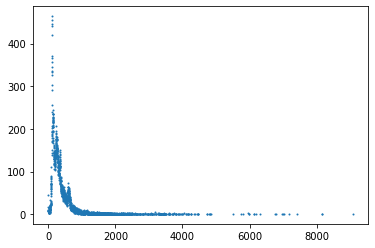

464


In [12]:
plt.scatter(length, freq, s=1)
plt.show()
print(max(freq))

In [13]:
# so I determined to divide each document to chunks contains 200 words, and padding if length < 200
print(Settings.seq_size)

200


In [14]:
records = list()
for label, words in data_list:
    sentences = FileUtils.divide_sentence(words, Settings.seq_size)
    for s in sentences:
        records.append([label, s])

In [15]:
print(len(records))

133989


In [16]:
print(records[0])

[1, [252340, 270020, 231952, 42995, 177029, 121779, 256593, 7887, 35773, 56023, 258524, 200874, 286144, 213094, 71199, 219665, 147924, 176474, 177029, 241491, 200874, 49830, 157410, 86839, 14031, 256593, 284937, 25418, 226098, 154142, 120378, 166719, 295541, 91005, 47795, 105383, 261583, 258524, 286144, 0, 125558, 16462, 135092, 281306, 181878, 299051, 6329, 200874, 151435, 39892, 117442, 269440, 267813, 98927, 280725, 7868, 122346, 62171, 183417, 258711, 16490, 726, 254115, 200874, 42501, 91152, 107111, 223237, 130833, 84894, 166719, 205112, 272229, 96910, 181066, 221648, 117442, 32423, 16490, 254217, 39892, 261808, 117442, 151435, 16490, 212543, 56902, 183417, 39892, 58595, 107111, 244824, 182721, 81029, 221648, 117442, 292303, 39892, 117442, 59483, 261808, 77662, 252340, 44132, 7747, 167861, 267249, 266063, 167258, 20561, 217573, 209326, 67170, 76879, 101213, 265594, 73122, 78447, 81029, 249597, 134722, 264529, 126296, 71253, 77662, 221648, 213582, 0, 48517, 16490, 250615, 139016, 2

## Build dataset

In [17]:
total_size = len(records)
train_size = int(total_size * 0.8)
valid_size = int(total_size * 0.1)
test_size = total_size - train_size - valid_size

In [18]:
print(train_size, test_size, valid_size)

107191 13400 13398


In [19]:
index_list = [i for i in range(total_size)]
random.seed(516)
random.shuffle(index_list)
train_indice = index_list[:train_size]
valid_indice = index_list[train_size: train_size + valid_size]
test_indice = index_list[-test_size:]

In [20]:
def build_set(set_name, indice, all_data):
    def create_label(label_index):
        """
        Turn label scalar into a one hot vector
        """
        res = [0 for i in range(14)]
        res[label_index-1] = 1 # because we start at 1
        return res
    
    n = len(indice)
    dataset = h5py.File(set_name, "a")
    dataset.create_dataset('label', shape=(n, 14), dtype=int)
    dataset.create_dataset('chunk', shape=(n, Settings.seq_size), dtype=int)
    
    for i, index in enumerate(indice):
        label, words = all_data[index]
        dataset["label"][i] = create_label(label)
        dataset["chunk"][i] = words
    dataset.close()
    return      

In [21]:
build_set(Settings.train_path, train_indice, records)

In [22]:
build_set(Settings.valid_path, valid_indice, records)

In [23]:
build_set(Settings.test_path, test_indice, records)

In [26]:
t_set = h5py.File(Settings.test_path, 'r')
print(t_set['label'][:5])
print(t_set['chunk'][1])

[[0 0 0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 0 0 0]]
[287556  94680 298785 228076 101661 216246  84356 268894  22879  81019
  27582 221648  71253  71253  54522 205673  18926 181971  58131      0
 250825 211724  65161 135639 182399  84356  78977 292239 185147  62530
 187528  70935 175527 211885      0 135639 269386 217262   7747  99965
  44132 232673 211724 173763  68540 115622  84356 147517  13368 277622
  62530 269386 175527  38998    478   8432 207278  99965 291491 210340
  84356 281310 243297   8432 230373 280248  88278 118101      0  99965
 147517 185147 175527 143406  84356 290461 210340 262307  62530 276047
  86831 147936 246000 268600 196521 147517   8432  35203  33377  84356
 275760  75919 277350 236452 200660 168036  28154 269386  84356  27251
   3729 211724 267392 157982 270864  84356 262532  84356 269386 173763
 101661  84356 185147 300157  84356      0 158029 291081 233573